<a href="https://colab.research.google.com/github/TaliNatan/DSPS_TNatan/blob/main/HW3_TNatan/KS_earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1. What is the test's Null Hypothsis that the K-S test tests? <br>
A1. This data is all from the same distribution.

Q2. What is the "statistic" or "pivotal quantity" that the test uses? <br>
A2.The KS statistic (d_kl) is the “maximum difference, in absolute value, between the rescaled cumulative distributions of the two data sets” (Corral). The d_kl value can be used to compare the theoretical culumative distribution function.

Q3. What does the probability distribution of this statistic depend on?<br>
A3. The statistics we care about in this project are the inter-event-timing of the earthquakes. These are ultimatley what we are doing the KS test on (grouped by earthquake magnitudes).
    
Q4. Did the author comply to reproducibility standards? <br>
A4. Not quite, the link to the data used for the paper is dead but they did describe their method relativley well.

# Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats

# Data Ingestion

In [2]:
eqdata = pd.read_csv('earthquakes.csv', delimiter = ' ', skipinitialspace=True, header=0, skipfooter=2)
eqdata.rename({"#YYY/MM/DD": "date", "HH:mm:SS.ss": "time", "MAG":"mag"},axis=1,inplace=True)
eqdata["datetime"] = [eqdata.iloc[i]["date"]+" "+eqdata.iloc[i]["time"] for i in range(len(eqdata))]

/Users/tali/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
newdtcol = [] ### FROM SID

for dt in eqdata["datetime"]:
  mins = int(dt[14:16])
  secs = int(dt[17:19])

  if secs==60:
    newsecs = secs - 60
    newmins = mins + 1

    newdt = dt[:14] + str(newmins) + dt[16] + str(newsecs) + dt[19:]

  else:
    newdt = dt

  newdtcol.append(newdt)

eqdata["datetime"] = newdtcol
eqdata["datetime"] = pd.to_datetime(eqdata["datetime"])

In [4]:
### FROM FED
#this are snippits of code. This is not intended as a script that should run on its own.

# first I create the timetamps pairs for the beginning and end of the valid periods. 
# I do it with a for loop that appends pairs of timestamps to a list that I create at the beginning

############
# create empty container
ss = []

# loop through all year pairs as year and fraction of year
for t in [(1984, 1986.5), 
          (1990.3, 1992.1), 
          (1994.6, 1995.6),
          (1996.1,1996.5), 
          (1997,1997.6), 
          (1997.75,1998.15), 
          (1998.25,1999.35), 
          (2000.55,2000.8),
          (2000.9 ,2001.25), 
          (2001.6 ,2002), 
          (2002.5 ,2003)]:
    
    # for each pair I convert the year to datetime (easy)
    # then I convert the fraction of year and convert it to days and convert that to a delta-time
    # finally I add that deltatime to the year datetime. 
    ss.append((pd.to_datetime(int(t[0]), format="%Y") 
        + pd.Timedelta('%.f days'%((t[0] - int(t[0])) * 365.25)),
               pd.to_datetime(int(t[1]), format="%Y") 
        + pd.Timedelta('%.f days'%((t[1] - int(t[1])) * 365.25))))


############

print ("the {} timestamp pairs that are the boundaries of good data periods are:".format(len(ss)))


############

# data between start and end of first time period
gooddates = (((eqdata.datetime >= ss[0][0]) * (eqdata.datetime <= ss[0][1])) +\
        # data between start and end of second time period
        ((eqdata.datetime >=ss [1][0]) * (eqdata.datetime <= ss[1][1])) +\
        ((eqdata.datetime >=ss [2][0]) * (eqdata.datetime <= ss[2][1])) +\
        ((eqdata.datetime >=ss [3][0]) * (eqdata.datetime <= ss[3][1])) +\
        ((eqdata.datetime >=ss [4][0]) * (eqdata.datetime <= ss[4][1])) +\
        ((eqdata.datetime >=ss [5][0]) * (eqdata.datetime <= ss[5][1])) +\
        ((eqdata.datetime >=ss [6][0]) * (eqdata.datetime <= ss[6][1])) +\
        ((eqdata.datetime >=ss [7][0]) * (eqdata.datetime <= ss[7][1])) +\
        ((eqdata.datetime >=ss [8][0]) * (eqdata.datetime <= ss[8][1])) +\
        ((eqdata.datetime >=ss [9][0]) * (eqdata.datetime <= ss[9][1])) +\
        # data between start and end of last time period
        ((eqdata.datetime >=ss [10][0]) * (eqdata.datetime <= ss[10][1])\
        ).values)

the 11 timestamp pairs that are the boundaries of good data periods are:


In [5]:
good_eqdata = eqdata[gooddates]
good_eqdata['time_diff'] = good_eqdata['datetime'].diff()
good_eqdata = good_eqdata[['date','time','mag','datetime', 'time_diff']]

/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_76835/2302533918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_eqdata['time_diff'] = good_eqdata['datetime'].diff()


In [6]:
good_eqdata = good_eqdata.tail(-1)

# Data Exploration

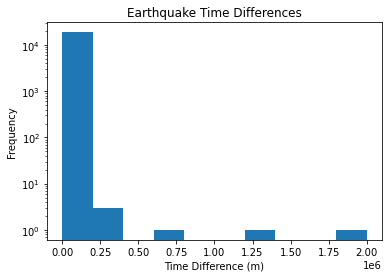

In [7]:
(good_eqdata["time_diff"]/pd.Timedelta(minutes=1)).plot(kind="hist", logy=True, title="Earthquake Time Differences")
plt.xlabel('Time Difference (m)')
plt.show()

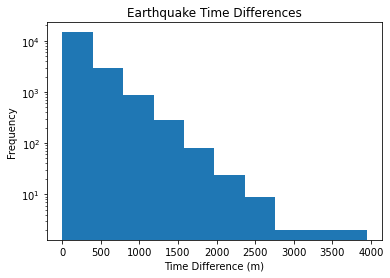

In [8]:
# FROM SHAR

month = (365.25/12)*24*60*60*10**9
map2 = good_eqdata["time_diff"] < np.timedelta64(int(month))
(good_eqdata["time_diff"][map2]/pd.Timedelta(minutes=1)).plot(kind="hist", logy=True,title="Earthquake Time Differences", xlabel="time differences (minutes)") 
#putting it in minutes bc it needs to be a diferent object type (not a timedelta)
plt.xlabel('Time Difference (m)')
plt.show()

# Data Analysis
$\alpha$ = 0.003

In [9]:
good_eqdata = good_eqdata[map2]

## For m = 0.01

In [10]:
m1 = good_eqdata[(good_eqdata[['mag']] >= 2).any(axis=1)]
m2 = good_eqdata[(good_eqdata[['mag']] >= 2.5).any(axis=1)]
m3 = good_eqdata[(good_eqdata[['mag']] >= 3).any(axis=1)]
m4 = good_eqdata[(good_eqdata[['mag']] >= 3.5).any(axis=1)]
m5 = good_eqdata[(good_eqdata[['mag']] >= 4).any(axis=1)]

In [11]:
m = 0.01

m1["time_diff_norm"] = m1["time_diff"] / m1["time_diff"].mean()
m1 = m1[(m1[["time_diff_norm"]] >= m).any(axis=1)]
m1["time_diff_norm"] = m1["time_diff_norm"] / m1["time_diff_norm"].mean()
m1 = m1[(m1[["time_diff_norm"]] >= m).any(axis=1)]

m2["time_diff_norm"] = m2["time_diff"] / m2["time_diff"].mean()
m2 = m2[(m2[["time_diff_norm"]] >= m).any(axis=1)]
m2["time_diff_norm"] = m2["time_diff_norm"] / m2["time_diff_norm"].mean()
m2 = m2[(m2[["time_diff_norm"]] >= m).any(axis=1)]

m3["time_diff_norm"] = m3["time_diff"] / m3["time_diff"].mean()
m3 = m3[(m3[["time_diff_norm"]] >= m).any(axis=1)]
m3["time_diff_norm"] = m3["time_diff_norm"] / m3["time_diff_norm"].mean()
m3 = m3[(m3[["time_diff_norm"]] >= m).any(axis=1)]

m4["time_diff_norm"] = m4["time_diff"] / m4["time_diff"].mean()
m4 = m4[(m4[["time_diff_norm"]] >= m).any(axis=1)]
m4["time_diff_norm"] = m4["time_diff_norm"] / m4["time_diff_norm"].mean()
m4 = m4[(m4[["time_diff_norm"]] >= m).any(axis=1)]

m5["time_diff_norm"] = m5["time_diff"] / m5["time_diff"].mean()
m5 = m5[(m5[["time_diff_norm"]] >= m).any(axis=1)]
m5["time_diff_norm"] = m5["time_diff_norm"] / m5["time_diff_norm"].mean()
m5 = m5[(m5[["time_diff_norm"]] >= m).any(axis=1)]


/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_76835/2639983251.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m2["time_diff_norm"] = m2["time_diff"] / m2["time_diff"].mean()
/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_76835/2639983251.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m3["time_diff_norm"] = m3["time_diff"] / m3["time_diff"].mean()
/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_76835/2639983251.py:18: SettingWithCopyWarning: 
A value is trying t

In [12]:
m1.shape[0],m2.shape[0],m3.shape[0],m4.shape[0],m5.shape[0]

(17949, 5389, 1350, 390, 109)

In [13]:
d12, p12 = sp.stats.kstest(m1["time_diff_norm"], m2["time_diff_norm"])
d13, p13 = sp.stats.kstest(m1["time_diff_norm"], m3["time_diff_norm"])
d14, p14 = sp.stats.kstest(m1["time_diff_norm"], m4["time_diff_norm"])
d15, p15 = sp.stats.kstest(m1["time_diff_norm"], m5["time_diff_norm"])

d21, p21 = sp.stats.kstest(m2["time_diff_norm"], m1["time_diff_norm"])
d23, p23 = sp.stats.kstest(m2["time_diff_norm"], m3["time_diff_norm"])
d24, p24 = sp.stats.kstest(m2["time_diff_norm"], m4["time_diff_norm"])
d25, p25 = sp.stats.kstest(m2["time_diff_norm"], m5["time_diff_norm"])

d31, p31 = sp.stats.kstest(m3["time_diff_norm"], m1["time_diff_norm"])
d32, p32 = sp.stats.kstest(m3["time_diff_norm"], m2["time_diff_norm"])
d34, p34 = sp.stats.kstest(m3["time_diff_norm"], m4["time_diff_norm"])
d35, p35 = sp.stats.kstest(m3["time_diff_norm"], m5["time_diff_norm"])

d41, p41 = sp.stats.kstest(m4["time_diff_norm"], m1["time_diff_norm"])
d42, p42 = sp.stats.kstest(m4["time_diff_norm"], m2["time_diff_norm"])
d43, p43 = sp.stats.kstest(m4["time_diff_norm"], m3["time_diff_norm"])
d45, p45 = sp.stats.kstest(m4["time_diff_norm"], m5["time_diff_norm"])

d51, p51 = sp.stats.kstest(m5["time_diff_norm"], m1["time_diff_norm"])
d52, p52 = sp.stats.kstest(m5["time_diff_norm"], m2["time_diff_norm"])
d53, p53 = sp.stats.kstest(m5["time_diff_norm"], m3["time_diff_norm"])
d54, p54 = sp.stats.kstest(m5["time_diff_norm"], m4["time_diff_norm"])

table = np.array([['x', p12, p13, p14, p15],
                 [d21,'x', p23, p24, p25],
                 [d31, d32,'x', p34, p35],
                 [d41, d42, d43,'x', p45],
                 [d51, d52, d53, d54, 'x']])

table

array([['x', '0.34633073747555965', '0.3616348392641998',
        '0.0941819605057247', '0.13173960486223132'],
       ['0.014481723494396775', 'x', '0.6912160353648216',
        '0.2279603907624933', '0.15147780568900537'],
       ['0.025914907051460656', '0.021487392012535824', 'x',
        '0.35065062280625137', '0.15913589169362063'],
       ['0.06279672747999676', '0.05413924851668404',
        '0.05293447293447293', 'x', '0.7498322379855523'],
       ['0.11063967684177545', '0.10827696922545246',
        '0.11023445463812437', '0.07108915549282521', 'x']], dtype='<U32')

| m = 0.01 | N | M >= 2.0 | M >= 2.5 | M >= 3.0 | M >= 3.5 | M >= 4.0 |
| --- | --- | --- | --- | --- | --- | --- |
|M >= 2.0 | 17949 | - | 34.6% | 36.2% | 9.4% | 13.2% |
|M >= 2.5 | 5389 | 0.014 | - | 69.1% | 22.8% | 15.1% |
|M >= 3.0 | 1350 | 0.026 | 0.021 | - | 35.1% | 15.9% |
|M >= 3.5 | 390 | 0.063 | 0.054 | 0.053 | - | 75.0% |
|M >= 4.0 | 109 | 0.111 | 0.108 | 0.110 | 0.071 | - |

P value (percentage) and d_kl statistics above and below the diagonal respectivley for rescaled data with lower cuttoff m = 0.01. Based on an $\alpha$ = 0.003, the scaling hypothesis (all the magnitudes follow the same timing distribution) cannot be rejected.

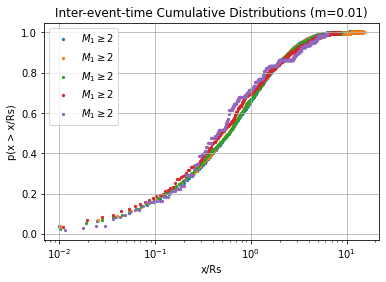

In [14]:
plt.scatter(np.histogram(m1["time_diff_norm"], bins = 1000)[1][:-1] / m1["time_diff_norm"].mean(), np.cumsum(np.histogram(m1["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m1["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m2["time_diff_norm"], bins = 1000)[1][:-1] / m2["time_diff_norm"].mean(), np.cumsum(np.histogram(m2["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m2["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m3["time_diff_norm"], bins = 1000)[1][:-1] / m3["time_diff_norm"].mean(), np.cumsum(np.histogram(m3["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m3["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m4["time_diff_norm"], bins = 1000)[1][:-1] / m4["time_diff_norm"].mean(), np.cumsum(np.histogram(m4["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m4["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m5["time_diff_norm"], bins = 1000)[1][:-1] / m5["time_diff_norm"].mean(), np.cumsum(np.histogram(m5["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m5["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.legend(loc = 'upper left')
plt.xlabel("x/Rs")
plt.ylabel("p(x > x/Rs)")
plt.xscale("log")
plt.title("Inter-event-time Cumulative Distributions (m=0.01)")
plt.grid()
plt.show()

The above plot shows the inter-event-timing cumulative distribution with cutoff m = 0.01 for 5 magnitude bins ($M_1 \geq 2$, $M_2 \geq 2.5$, $M_3 \geq 3$, $M_4 \geq 3.5$, $M_5 \geq 4$). The data has been rescaled along the x-axis such that the time difference are divided by the mean time difference within that bin. As we can see, all of these distributions overlap with one another/are very similar shapes. The above table shows that they are statitically similar to one another.

## For m = 0.001

In [15]:
m1_1 = good_eqdata[(good_eqdata[['mag']] >= 2).any(axis=1)]
m2_1 = good_eqdata[(good_eqdata[['mag']] >= 2.5).any(axis=1)]
m3_1 = good_eqdata[(good_eqdata[['mag']] >= 3).any(axis=1)]
m4_1 = good_eqdata[(good_eqdata[['mag']] >= 3.5).any(axis=1)]
m5_1 = good_eqdata[(good_eqdata[['mag']] >= 4).any(axis=1)]

In [16]:
m_1 = 0.001

m1_1["time_diff_norm"] = m1_1["time_diff"] / m1_1["time_diff"].mean()
m1_1 = m1_1[(m1_1[["time_diff_norm"]] >= m_1).any(axis=1)]
m1_1["time_diff_norm"] = m1_1["time_diff_norm"] / m1_1["time_diff_norm"].mean()
m1_1 = m1_1[(m1_1[["time_diff_norm"]] >= m_1).any(axis=1)]

m2_1["time_diff_norm"] = m2_1["time_diff"] / m2_1["time_diff"].mean()
m2_1 = m2_1[(m2_1[["time_diff_norm"]] >= m_1).any(axis=1)]
m2_1["time_diff_norm"] = m2_1["time_diff_norm"] / m2_1["time_diff_norm"].mean()
m2_1 = m2_1[(m2_1[["time_diff_norm"]] >= m_1).any(axis=1)]

m3_1["time_diff_norm"] = m3_1["time_diff"] / m3_1["time_diff"].mean()
m3_1 = m3_1[(m3_1[["time_diff_norm"]] >= m_1).any(axis=1)]
m3_1["time_diff_norm"] = m3_1["time_diff_norm"] / m3_1["time_diff_norm"].mean()
m3_1 = m3_1[(m3_1[["time_diff_norm"]] >= m_1).any(axis=1)]

m4_1["time_diff_norm"] = m4_1["time_diff"] / m4_1["time_diff"].mean()
m4_1 = m4_1[(m4_1[["time_diff_norm"]] >= m_1).any(axis=1)]
m4_1["time_diff_norm"] = m4_1["time_diff_norm"] / m4_1["time_diff_norm"].mean()
m4_1 = m4_1[(m4_1[["time_diff_norm"]] >= m_1).any(axis=1)]

m5_1["time_diff_norm"] = m5_1["time_diff"] / m5_1["time_diff"].mean()
m5_1 = m5_1[(m5_1[["time_diff_norm"]] >= m_1).any(axis=1)]
m5_1["time_diff_norm"] = m5_1["time_diff_norm"] / m5_1["time_diff_norm"].mean()
m5_1 = m5_1[(m5_1[["time_diff_norm"]] >= m_1).any(axis=1)]

/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_76835/2202321450.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m2_1["time_diff_norm"] = m2_1["time_diff"] / m2_1["time_diff"].mean()
/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_76835/2202321450.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m3_1["time_diff_norm"] = m3_1["time_diff"] / m3_1["time_diff"].mean()
/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_76835/2202321450.py:18: SettingWithCopyWarning: 
A value

In [17]:
m1_1.shape[0],m2_1.shape[0],m3_1.shape[0],m4_1.shape[0],m5_1.shape[0]

(18709, 5669, 1443, 422, 115)

In [18]:
d12_1, p12_1 = sp.stats.kstest(m1_1["time_diff_norm"], m2_1["time_diff_norm"])
d13_1, p13_1 = sp.stats.kstest(m1_1["time_diff_norm"], m3_1["time_diff_norm"])
d14_1, p14_1 = sp.stats.kstest(m1_1["time_diff_norm"], m4_1["time_diff_norm"])
d15_1, p15_1 = sp.stats.kstest(m1_1["time_diff_norm"], m5_1["time_diff_norm"])

d21_1, p21_1 = sp.stats.kstest(m2_1["time_diff_norm"], m1_1["time_diff_norm"])
d23_1, p23_1 = sp.stats.kstest(m2_1["time_diff_norm"], m3_1["time_diff_norm"])
d24_1, p24_1 = sp.stats.kstest(m2_1["time_diff_norm"], m4_1["time_diff_norm"])
d25_1, p25_1 = sp.stats.kstest(m2_1["time_diff_norm"], m5_1["time_diff_norm"])

d31_1, p31_1 = sp.stats.kstest(m3_1["time_diff_norm"], m1_1["time_diff_norm"])
d32_1, p32_1 = sp.stats.kstest(m3_1["time_diff_norm"], m2_1["time_diff_norm"])
d34_1, p34_1 = sp.stats.kstest(m3_1["time_diff_norm"], m4_1["time_diff_norm"])
d35_1, p35_1 = sp.stats.kstest(m3_1["time_diff_norm"], m5_1["time_diff_norm"])

d41_1, p41_1 = sp.stats.kstest(m4_1["time_diff_norm"], m1_1["time_diff_norm"])
d42_1, p42_1 = sp.stats.kstest(m4_1["time_diff_norm"], m2_1["time_diff_norm"])
d43_1, p43_1 = sp.stats.kstest(m4_1["time_diff_norm"], m3_1["time_diff_norm"])
d45_1, p45_1 = sp.stats.kstest(m4_1["time_diff_norm"], m5_1["time_diff_norm"])

d51_1, p51_1 = sp.stats.kstest(m5_1["time_diff_norm"], m1_1["time_diff_norm"])
d52_1, p52_1 = sp.stats.kstest(m5_1["time_diff_norm"], m2_1["time_diff_norm"])
d53_1, p53_1 = sp.stats.kstest(m5_1["time_diff_norm"], m3_1["time_diff_norm"])
d54_1, p54_1 = sp.stats.kstest(m5_1["time_diff_norm"], m4_1["time_diff_norm"])

table_1 = np.array([['x', p12_1, p13_1, p14_1, p15_1],
                 [d21_1,'x', p23_1, p24_1, p25_1],
                 [d31_1, d32_1,'x', p34_1, p35_1],
                 [d41_1, d42_1, d43_1,'x', p45_1],
                 [d51_1, d52_1, d53_1, d54_1, 'x']])

table_1

array([['x', '0.0669668534606861', '0.06814506112193086',
        '0.035876140569564896', '0.10755630717788713'],
       ['0.019718196796738002', 'x', '0.37599221164951235',
        '0.14803517605710703', '0.13456270453170205'],
       ['0.035383039659056564', '0.026729607608069417', 'x',
        '0.3690110578604402', '0.16362853561241786'],
       ['0.06934860911657947', '0.05711155456757839',
        '0.0501768629730715', 'x', '0.743442522464792'],
       ['0.11171884259377607', '0.10788192074363241',
        '0.1067160806291241', '0.0694415825262724', 'x']], dtype='<U32')

| m = 0.01 | N | M >= 2.0 | M >= 2.5 | M >= 3.0 | M >= 3.5 | M >= 4.0 |
| --- | --- | --- | --- | --- | --- | --- |
|M >= 2.0 | 18709 | - | 6.7% | 6.8% | 3.6% | 10.7% |
|M >= 2.5 | 5669 | 0.020 | - | 37.6% | 14.8% | 13.4% |
|M >= 3.0 | 1443 | 0.035 | 0.027 | - | 36.9% | 16.36% |
|M >= 3.5 | 422 | 0.069 | 0.057 | 0.050 | - | 74.3% |
|M >= 4.0 | 115 | 0.112 | 0.108 | 0.107 | 0.069 | - |

P value (percentage) and d_kl statistics above and below the diagonal respectivley for rescaled data with lower cuttoff m = 0.001. Based on an $\alpha$ = 0.003, the scaling hypothesis (all the magnitudes follow the same timing distribution) cannot be rejected.

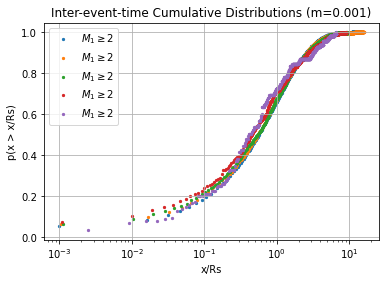

In [19]:
plt.scatter(np.histogram(m1_1["time_diff_norm"], bins = 1000)[1][:-1] / m1_1["time_diff_norm"].mean(), np.cumsum(np.histogram(m1_1["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m1_1["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m2_1["time_diff_norm"], bins = 1000)[1][:-1] / m2_1["time_diff_norm"].mean(), np.cumsum(np.histogram(m2_1["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m2_1["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m3_1["time_diff_norm"], bins = 1000)[1][:-1] / m3_1["time_diff_norm"].mean(), np.cumsum(np.histogram(m3_1["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m3_1["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m4_1["time_diff_norm"], bins = 1000)[1][:-1] / m4_1["time_diff_norm"].mean(), np.cumsum(np.histogram(m4_1["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m4_1["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.scatter(np.histogram(m5_1["time_diff_norm"], bins = 1000)[1][:-1] / m5_1["time_diff_norm"].mean(), np.cumsum(np.histogram(m5_1["time_diff_norm"], bins = 1000)[0])/np.cumsum(np.histogram(m5_1["time_diff_norm"], bins = 1000)[0])[-1], s = 5, label = r'$M_1 \geq 2$')
plt.legend(loc = 'upper left')
plt.xlabel("x/Rs")
plt.ylabel("p(x > x/Rs)")
plt.xscale("log")
plt.title("Inter-event-time Cumulative Distributions (m=0.001)")
plt.grid()
plt.show()

The above plot shows the inter-event-timing cumulative distribution with cutoff m = 0.001 for 5 magnitude bins ($M_1 \geq 2$, $M_2 \geq 2.5$, $M_3 \geq 3$, $M_4 \geq 3.5$, $M_5 \geq 4$). The data has been rescaled along the x-axis such that the time difference are divided by the mean time difference within that bin. As we can see, all of these distributions overlap with one another/are very similar shapes. The above table shows that they are statitically similar to one another.

# Conclusions

Did you find any statistical significant differences between the distributions? What does it mean? Is your result identical to Correll's 2018? Why or why not? Discuss!

For both m = 0.01, and 0.001, all of our results are greater than our chosen $\alpha$ value of 0.003. My propbabilities are higher for m = 0.01 than 0.001 which may indicate aftershocks are still found in the 0.001 cutoff and these effect the similaries of the distributions. My results are not exactly identical to Correll (2018) possibly for a few reasons: 

1. we used different datasets and despite both sets being large, maybe they are not big enough
2. their data was cleaned/normalized/thresholded differently than our method (which was supposed to follow theirs but maybe they left out steps)

Nevertheless, our conclusions are the same to Correll (2018).